In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample
import os
from datetime import datetime
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on Numpy v{np.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.11.0
Running on Numpy v1.26.4


In [4]:
def d2r(x): return np.deg2rad(x)
def r2d(x): return np.rad2deg(x)
def sin(x): return np.sin(x)
def cos(x): return np.cos(x)
def tan(x): return np.tan(x)
def log(x): return np.log(x)
def log10(x): return np.log10(x)
def exp(x):
    return np.exp(x)
def ln(x):
    return np.log(x)
def m_exponential(x,h,a0,k):
    # modified equation from Bach et al. 2024b
    eq = h* ((1-exp(-a0/k))*x - (1-exp(-x/k))*a0) / (1-(1+a0/k)*exp(-a0/k)) 
    return eq
def Pol_plot(plot_df):
    dic_style = {
        'marker':{
            'Lup':'s','Bel2009':'o','Gil12':'<','Gil17':'^',
            'Tor':'>','For06':'x','Devo06':'v','Devo16':'d',
            'Lopez19':'8','MSI':'X', 'Geem':'p','WFGS':'P',
            'ishiguro21':'*','Bendjoya2022':'D','Gil-Hutton2023':'4',
            'Kwon2023':'+'
                  },
        'mfc':{
            'Lup':'none','Bel2009':'none','Gil12':'none','Gil17':'none',
            'Tor':'none','For06':'none','Devo06':'none','Devo16':'none',
            'Lopez19':'none','MSI':'none', 'Geem':'none','WFGS':'none',
            'ishiguro21':'none','Bendjoya2022':'none','Gil-Hutton2023':'none','Kwon2023':'none'
              }
        }
    dic_color = {'V':'#4daf4a','V  ':'#4daf4a','R':'#e41a1c','Rc':'#e41a1c','G':'b','B':'purple'}
    # Color blind friendly
    reference = {'Lup':'Lupishko et al. (2019)',
                 'Bel2009':'Belsekaya et al. (2009)',
                 'Gil12':'Gil Hutton et al. (2012)',
                 'Gil17': 'Gil Hutton et al. (2017)',             
                 'For06':'Fornasier et al. (2006)',   
                 'Tor':'Cellino et al. (2005)',
                 'Devo06':'Devogèle et al. (2006)', 
                 'Devo16':'Devogèle et al. (2016)', 
                 'Lopez19':'Lopez-Sisterna et al. (2019)'  ,
                 'MSI':'MSI',
                 'WFGS':'WFGS',
                 'Geem':'Geem et al. (2022)',
                 'ishiguro21':'Ishiguro et al. (2021)',
                'Bendjoya2022':'Bendjoya et al. (2022)',
                 'Gil-Hutton2023':'Gil-Hutton et al. (2023)',
                'Kwon2023':'Kwon et al. (2023)'}
    ref_i = set(plot_df['ref'].values)
    ID = plot_df['ID'].values[0]
    for r in ref_i:
        plot_df_ = plot_df[plot_df['ref']==r]
        for fil in set(set(plot_df['Filter'].values)):
            plot_df__ = plot_df_[plot_df_['Filter']==fil]
            if r == 'MSI' or r == 'WFGS':
                ms=12
            else:
                ms=8
            ax.errorbar(plot_df__['alpha'],plot_df__['Pr'],yerr=plot_df__['ePr'],
                       ls='',marker=dic_style['marker'][r],mfc=dic_style['mfc'][r],
                        mec=dic_color[fil],ecolor=dic_color[fil],ms=ms,
                       elinewidth=1)
        ax.errorbar(-99,-99,
                    ls='',marker=dic_style['marker'][r],mfc=dic_style['mfc'][r],
                    mec='k',elinewidth=1,label=reference[r])    
    fff = np.array(list(set(plot_df['Filter'].values)), dtype='<U4')

    fff[fff == 'V'] = '2.V'
    fff[fff == 'R'] = '3.R'
    fff[fff == 'Rc'] = '4.Rc'
    for n,fil in enumerate(sorted(fff)):  
        fil = fil.split('.')[-1]
        ax.annotate(fil,color=dic_color[fil],
                   xy = (4, 3-0.5*n),fontsize=18)
    now = datetime.now()
    text = 'Created by Geem, J. on {0}'.format(now.strftime("%Y/%m/%d %H:%M (KST)")) \
    + '\nOnly data of phase angles<35deg is used for fitting.'
    ax.annotate(text, xy=(18,-2.6),fontsize=6)
    ax.set_xlim(0,36)
    ax.set_ylim(-2.9,3.5)
    ax.axhline(0,ls=':',color='gray')
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(1))        
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.tick_params(axis = 'both', which='minor', length=5)
    ax.tick_params(axis ='both',which='both', direction='in')
    ax.tick_params(axis ='both',which='major', length=10)
    ax.tick_params(axis = 'both')
    ax.tick_params(axis='both',labelsize=17)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    
path = os.path.join(os.getenv("HOME"),'Dropbox','Research')
AST = pd.read_csv(os.path.join(path,'Archive/Asteroid.csv'))
Lup = pd.read_csv(os.path.join(path,'Archive/asteroid_polarimetric_database_V1_0','data','apd.csv'))  #single data
Bel = pd.read_csv(os.path.join(path,'Archive/Belskaya2009','data','belpolar.csv')) #single data
Gil12 = pd.read_csv(os.path.join(path,'Archive/Gil_hutton2012','table1.csv'),delimiter='\t') #single data
Torino = pd.read_csv(os.path.join(path,'Archive/Torino','data','torinopol.csv')) #single data
For06 = pd.read_csv(os.path.join(path,'Archive/Fornasier_2006.csv'))
Gil17 = pd.read_csv(os.path.join(path,'Archive/Gil_hutton2017','table1.csv'),delimiter='\t') #single data
Devo06 = pd.read_csv(os.path.join(path,'Archive/Devogele_2006.csv'))
Lopez19 = pd.read_csv(os.path.join(path,'Archive/Lopez','table1.csv'))
Pirka = pd.read_csv(os.path.join(path,'Archive/Pirka_2020_Obs.csv'))
Tri = pd.read_csv(os.path.join(path,'Archive/EAR_A_3_RDR_TRIAD_POLARIMETRY_V2_1','data','polar.csv')) #index data
Gil17_indx = pd.read_csv(os.path.join(path,'Archive/Gil_hutton2017','parametros-ABC.csv')) #index data
Torino_indx = pd.read_csv(os.path.join(path,'Archive/Torino','data','table5.csv')) #index data
Goidet = pd.read_csv(os.path.join(path,'Archive/Goidet_1995.csv')) #index data
Lopez19_param = pd.read_csv(os.path.join(path,'Archive/Lopez','pol_param.csv'))#index data

Geem_observed_tar = [19, 24, 41, 49, 54, 58, 66, 70, 91, 95, 99, 105, 111, 
                     128, 142, 144, 147, 162, 173, 176, 207, 209, 233, 238, 
                     240, 257, 282, 284, 308, 357, 368, 375, 398, 405, 410, 
                     418, 442, 490, 503, 586, 602, 618, 771, 776, 821, 1015, 
                     1201, 1542, 1754, 1795, 1867, 2569]
##======================================================================================================
##GIVEN CONDITION
##======================================================================================================
#EXPONENTIAL
Boundary_exp = pd.DataFrame({'h':[0.01,0.5], #lower , upper boundary
                           'a0':[10,30],
                           'k':[0,500]})
p0_exp = [ 0.35, 20,  100]

##======================================================================================================
List = pd.read_csv(os.path.join(path,'Hydrated_asteroid', 'Manuscript','Archive_compile.csv'))
pol_df = pd.read_csv(os.path.join(path,'Hydrated_asteroid','Manuscript','Pol_param_20240325.csv'))


/var/folders/3y/81tkh9q91_bg2126ywrxppk80000gn/T/ipykernel_24623/905422211.py:96: DtypeWarning: Columns (11,17,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  AST = pd.read_csv(os.path.join(path,'Archive/Asteroid.csv'))


70 -- 4


/var/folders/3y/81tkh9q91_bg2126ywrxppk80000gn/T/ipykernel_24623/2663484592.py:40: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_exp = pm.sample(2000, start=dict(h = p0_exp[0],
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, a0, k, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 1875 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


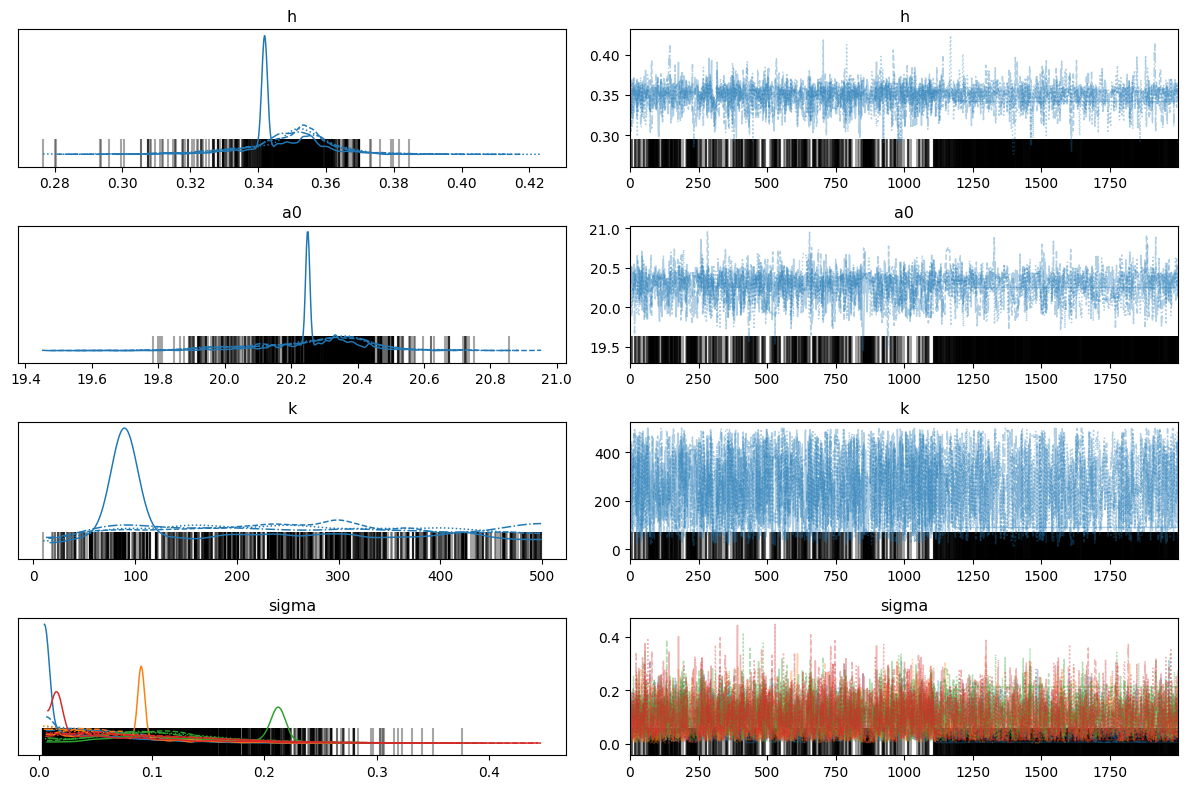

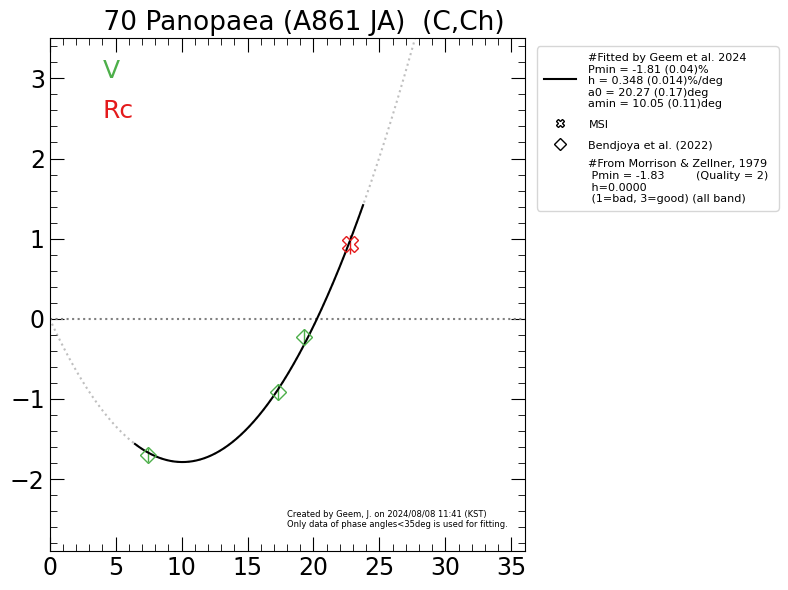

In [8]:
List = pd.read_csv(os.path.join(path,'Hydrated_asteroid', 'Manuscript','Archive_compile.csv'))

#Fitting the 70

for n,ast in enumerate([70]):
    ID = ast
    try:
        df = pd.read_csv(os.path.join(path,'Archive','Polarimetry_Ast_2','data','a{0:06d}.csv'.format(ast)))
    except:
        continue
    else:
        df = pd.read_csv(os.path.join(path,'Archive','Polarimetry_Ast_2','data','a{0:06d}.csv'.format(ast)))
    MSI = pd.read_csv(os.path.join(path,'Pirka_MSI/MSI_primitive_asteroids_2023.csv'))
    df_vr = pd.concat([df[df['Filter']=='V'],
                           df[df['Filter']=='R'],
                           df[df['Filter']=='Rc']])
    d_num = df_vr[df_vr['alpha']<35]
    d_num = d_num.drop_duplicates(['alpha', 'Pr', 'ePr'])
    
    #if data points are sufficient to fit.
    Pmin_flag = np.nan #or Pmin_flag = proxy
    print(ast,'--',len(d_num))
    if len(d_num)>=3:
        alpha = d_num['alpha'].values
        P = d_num['Pr'].values
        eP = d_num['ePr'].values

        #MCMC fitting   ===========================================================
        basic_model_exp = pm.Model()
        with basic_model_exp:
            h = pm.Uniform('h',  Boundary_exp['h'].values[0],  Boundary_exp['h'].values[1])
            a0 = pm.Uniform('a0', Boundary_exp['a0'].values[0], Boundary_exp['a0'].values[1])
            k = pm.Uniform('k', Boundary_exp['k'].values[0], Boundary_exp['k'].values[1])
            sigma = pm.HalfNormal("sigma",sigma=eP)
            P_alpha = m_exponential(alpha,h,a0,k)


            liklihood = pm.Normal('likelihood', mu=P_alpha, sigma=sigma, observed=P)
            start = {}
            trace_exp = pm.sample(2000, start=dict(h = p0_exp[0],
                                                  a0 = p0_exp[1],
                                                   k = p0_exp[2]))
        summary_exp = pm.summary(trace_exp, hdi_prob=0.6827).round(5)   
        pm.plot_trace(trace_exp)
        plt.tight_layout()
        plt.savefig(os.path.join(path,'Hydrated_asteroid',
                                 'pymc_result_a{0:07d}.png'.format(ast)))  # Save the plot as 'trace_plot.png'
        pm.summary(trace_exp, hdi_prob=0.6827).round(5)     
        
        
        
        #Bring Pmin and amin--------------------------------------------------
        h_post = np.concatenate(trace_exp.posterior['h'].values)
        a0_post = np.concatenate(trace_exp.posterior['a0'].values)
        k_post = np.concatenate(trace_exp.posterior['k'].values)
        log_exp = dict({'h':h_post, 'a0':a0_post, 'k':k_post})

        Pmin_mcmc_dist,amin_mcmc_dist = [],[]
        for i in range(len(log_exp['h'])):
            h_i = log_exp['h'][i]
            a0_i = log_exp['a0'][i]
            k_i = log_exp['k'][i]
            amin_i = - k_i*np.log(k_i*(1-np.exp(-a0_i/k_i))/a0_i)
            Pmin_i = m_exponential(amin_i, h_i, a0_i, k_i)
            Pmin_mcmc_dist.append(Pmin_i)
            amin_mcmc_dist.append(amin_i)

        Pmin_mcmc = np.median(Pmin_mcmc_dist)
        ePmin_mcmc_upper = np.percentile(Pmin_mcmc_dist,84.135) - Pmin_mcmc
        ePmin_mcmc_lower = Pmin_mcmc - np.percentile(Pmin_mcmc_dist,15.865)
        ePmin_mcmc = np.mean([ePmin_mcmc_upper,ePmin_mcmc_lower])

        amin_mcmc = np.median(amin_mcmc_dist)
        eamin_mcmc_upper = np.percentile(amin_mcmc_dist,84.135) - amin_mcmc
        eamin_mcmc_lower = amin_mcmc - np.percentile(amin_mcmc_dist,15.865)
        eamin_mcmc = np.mean([eamin_mcmc_upper,eamin_mcmc_lower])
        
        #Bring h and a0 -----------------------------------------------------
        h_mcmc, eh_mcmc = summary_exp['mean'][0], summary_exp['sd'][0]
        a0_mcmc, ea0_mcmc = summary_exp['mean'][1], summary_exp['sd'][1]
        k_mcmc, ek_mcmc = summary_exp['mean'][2], summary_exp['sd'][2]
        
        #Check the extrapolation----------------------------------------------
        ### Pmin & amin----
        num_pmin_left = d_num[d_num['alpha']<10]
        num_pmin_right = d_num[d_num['alpha']>10]
        num_pmin_right = num_pmin_right[num_pmin_right['alpha']<20]
        
        num_pmin = d_num[d_num['alpha']<13]
        num_pmin = num_pmin[num_pmin['alpha']>7]
        if (len(num_pmin_right)>0 and len(num_pmin_left)>0) or (len(num_pmin)>0):
            pass
        else:
            Pmin_mcmc, ePmin_mcmc = np.nan, np.nan
            amin_mcmc, eamin_mcmc = np.nan, np.nan
            
        ### h----
        num_h_up = d_num[d_num['alpha']>a0_mcmc]
        num_h_down = d_num[d_num['alpha']<a0_mcmc]
        if len(num_h_up)>0 and len(num_h_down) >0:
            pass
        else:
            h_mcmc, eh_mcmc = np.nan, np.nan
        
        ### a0----
        num_a0 = d_num[d_num['alpha']<a0_mcmc+2]
        num_a0 = num_a0[num_a0['alpha']>a0_mcmc-2]
        if len(num_a0)!=0 or str(h_mcmc)!='nan':
            pass
        else:
            a0_mcmc, ea0_mcmc = np.nan, np.nan
         
    else: #No enuough data. #Check proxy Pmin
        #Is this the targets observed by us?
        if ast in Geem_observed_tar:
            num_pmin = d_num[d_num['alpha']<13]
            num_pmin = num_pmin[num_pmin['alpha']>7]
            if len(num_pmin)>0:
                Pmin_mcmc = np.mean(num_pmin['Pr'])
                ePmin_mcmc = np.sqrt(np.sum(num_pmin['ePr']**2))
                Pmin_flag = 'proxy'
                amin_mcmc, eamin_mcmc = np.nan, np.nan
                h_mcmc, eh_mcmc = np.nan, np.nan
                a0_mcmc, ea0_mcmc = np.nan, np.nan
                print(Pmin, ePmin)
            else:
                Pmin_mcmc, ePmin_mcmc = np.nan, np.nan
            amin_mcmc, eamin_mcmc = np.nan, np.nan
            h_mcmc, eh_mcmc = np.nan, np.nan
            a0_mcmc, ea0_mcmc = np.nan, np.nan
                
        else:
            Pmin_mcmc, ePmin_mcmc = np.nan, np.nan
            amin_mcmc, eamin_mcmc = np.nan, np.nan
            h_mcmc, eh_mcmc = np.nan, np.nan
            a0_mcmc, ea0_mcmc = np.nan, np.nan

    #Save pol params ==========================================================
    pol_df = pd.concat([pol_df,pd.DataFrame({'ID':[ast],
                                            'Pmin':[Pmin_mcmc],
                                            'ePmin':[ePmin_mcmc],
                                            'h':[h_mcmc],
                                            'eh':[eh_mcmc],
                                            'a0':[a0_mcmc],
                                            'ea0':[ea0_mcmc],
                                            'amin':[amin_mcmc],
                                            'eamin':[eamin_mcmc],
                                            'Pmin_flag':[Pmin_flag]})])

    pol_df = pol_df.round({'Pmin':2,'ePmin':2,'h':3,'eh':3, 'a0':2,'ea0':2,
                     'amin':2,'eamin':2})
    pol_df.to_csv(os.path.join(path,'Hydrated_asteroid','Submitted_ver_2024/revision/S_type_fitting',
                               'Pol_param_20240517.csv'),
                 index=False)  
    
    
    #Ploting the figure ==========================================================

    Pmin_com = pd.DataFrame({'ID':[]})
    Pmin_com = pd.concat([Pmin_com,pd.DataFrame({'ID':[int(ID)]})])
    

    fig,ax = plt.subplots(1,1,figsize=(8,6))
    df_vr = df_vr.drop_duplicates(['alpha', 'Pr', 'ePr'])
    if len(df_vr)==0:
        continue
    Pol_plot(df_vr) 
    
    

    D2R = 3.14/180

    df_vr = df_vr[df_vr['alpha']<35]
    alpha = df_vr['alpha'].values
    P = df_vr['Pr'].values
    eP = df_vr['ePr'].values


    x = np.arange(min(df_vr['alpha'])-1, max(df_vr['alpha'])+1,0.01)
    if len(df_vr)>2 or Pmin_flag=='proxy':
        color=dict({'nan':'k','proxy':'none'})[str(Pmin_flag)]
        xx = np.arange(0,35,0.1)
        ax.plot(xx, m_exponential(xx, *summary_exp['mean'][0:3].values),ls=':',color='gray',alpha=0.5)
        ax.plot(x, m_exponential(x, *summary_exp['mean'][0:3].values),
               color=color, label='#Fitted by Geem et al. 2024\n'
                                 'Pmin = {0:.2f} ({1:.2f})%\n'
                                 'h = {2:.3f} ({3:.3f})%/deg\n'
                                 'a0 = {4:.2f} ({5:.2f})deg\n'
                                 'amin = {6:.2f} ({7:.2f})deg'.format(Pmin_mcmc, ePmin_mcmc,
                                                                   h_mcmc, eh_mcmc,
                                                                   a0_mcmc, ea0_mcmc,
                                                                   amin_mcmc, eamin_mcmc))
    


    #Bring the pol Param from the available literature===============
    liter_num = 0 #To plot the literatures
    geem_fit = 0
    if len(df_vr)>2 or Pmin_flag=='proxy':
        geem_fit = 1
    if ID in Tri['ID'].values:
        Tri_i = Tri[Tri['ID']==ID]
        ax.errorbar(df['alpha'],df['Pr'],
           ls='',zorder=11,
           label = '#From Morrison & Zellner, 1979 \n Pmin = {0:.2f} \
        (Quality = {1}) \n h={2:.4f}'.format(-1*Tri_i['Pmin'].values[0],Tri_i['Quality_Pmin'].values[0],Tri_i['h2'].values[0])+
            ' \n (1=bad, 3=good) (all band)')
        Pmin_com.loc[Pmin_com['ID'] ==ID,'Pmin_Mor'] = float("%.3f" % (-1*Tri_i['Pmin'].values[0]))
        Pmin_com.loc[Pmin_com['ID'] ==ID,'h_Mor'] = float("%.3f" % (Tri_i['h2'].values[0])) 
        Pmin_com.loc[Pmin_com['ID'] ==ID,'a0_Mor'] = float("%.3f" % (Tri_i['a02'].values[0])) 
        liter_num = liter_num+1



    if ID in Gil17_indx['ID'].values:
        Gil17_indx_i = Gil17_indx[Gil17_indx['ID']==ID]
        try:
            float(Gil17_indx_i['k'].values[0])
        except ValueError:
            h = np.nan
            eh = np.nan
        else:
            h = float(Gil17_indx_i['k'].values[0])
            eh = float(Gil17_indx_i['k_err'].values[0])
        ax.errorbar(df['alpha'],df['Pr'],
               ls='',zorder=11,
               label = '#From Gil 2017 \n Pmin = {0:.2f} ({1:.2f}) \
    \n h = {2:.4f} ({3:.4f})(V-band)) '.format(Gil17_indx_i['Pmin'].values[0],
                                                         Gil17_indx_i['Pmin_err'].values[0],
                                                        h,
                                                        eh))

        Pmin_com.loc[Pmin_com['ID'] ==ID,'Pmin_gil'] = float("%.3f" % Gil17_indx_i['Pmin'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'ePmin_gil'] = float("%.3f" % Gil17_indx_i['Pmin_err'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'h_gil'] = float("%.3f" % Gil17_indx_i['k'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'eh_gil'] = float("%.3f" % Gil17_indx_i['k_err'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'a0_gil'] = float("%.3f" % Gil17_indx_i['Ph0'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'ea0_gil'] = float("%.3f" % Gil17_indx_i['Ph0_err'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'amin_gil'] = float("%.3f" % Gil17_indx_i['Phmin'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'eamin_gil'] = float("%.3f" % Gil17_indx_i['Phmin_err'].values[0])
        liter_num = liter_num+1



    if ID in Torino_indx['ID'].values:
        Torino_indx_i = Torino_indx[Torino_indx['ID']==ID]
        try:
            float(Torino_indx_i['h'].values[0])
        except ValueError:
            h = np.nan
            eh = np.nan
        else:
            h = float(Torino_indx_i['h'].values[0])
            eh = float(Torino_indx_i['eh'].values[0])
        ax.errorbar(df['alpha'],df['Pr'],
               ls='',zorder=11,
               label = '#From Torino 2017 \n Pmin = {0:.2f} ({1:.2f}) \
    \n h = {2:.4f} ({3:.4f})(V, R-band)) '.format(Torino_indx_i['Pmin'].values[0],
                                                            Torino_indx_i['ePmin'].values[0],
                                                            h,
                                                            eh))    


        Pmin_com.loc[Pmin_com['ID'] ==ID,'Pmin_tor'] = float("%.3f" % Torino_indx_i['Pmin'].values[0])
        Pmin_com.loc[Pmin_com['ID'] ==ID,'ePmin_tor'] = float("%.3f" % Torino_indx_i['ePmin'].values[0])    
        Pmin_com.loc[Pmin_com['ID'] ==ID,'h_tor'] = h
        Pmin_com.loc[Pmin_com['ID'] ==ID,'eh_tor'] = eh  
        liter_num = liter_num+1



    if ID in Goidet['ID'].values:

        Goidet_i = Goidet[Goidet['ID']==ID]
        ax.errorbar(df['alpha'],df['Pr'],
               ls='',zorder=11,
               label = '#From Goidet 1995 \n Pmin = {0:.2f} ({1:.2f})\
    \n h = {2:.4f} ({3:.4f})(B,G-band)) '.format(Goidet_i['Pmin'].values[0],
                                                           Goidet_i['ePmin'].values[0],
                                                          Goidet_i['h'].values[0],
                                                          Goidet_i['eh'].values[0]))    


        Pmin_com.loc[Pmin_com['ID'] ==ID,'Pmin_goi'] = Goidet_i['Pmin'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'ePmin_goi'] = Goidet_i['ePmin'].values[0]       
        Pmin_com.loc[Pmin_com['ID'] ==ID,'h_goi'] = Goidet_i['h'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'eh_goi'] = Goidet_i['eh'].values[0]   
        Pmin_com.loc[Pmin_com['ID'] ==ID,'a0_goi'] = Goidet_i['a0'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'ea0_goi'] = Goidet_i['ea0'].values[0]   
        Pmin_com.loc[Pmin_com['ID'] ==ID,'amin_goi'] = Goidet_i['amin'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'eamin_goi'] = Goidet_i['eamin'].values[0]

        liter_num = liter_num+1


    if ID in Lopez19_param['ID'].values:
        Lopez19_param_i = Lopez19_param[Lopez19_param['ID']==ID]
        ax.errorbar(df['alpha'],df['Pr'],
               ls='',zorder=11,
               label = '#From Lopez 2019 \n Pmin = {0:.2f} ({1:.2f})\
    \n h = {2:.4f} ({3:.4f})(V-band)) '.format(Lopez19_param_i['Pmin'].values[0],
                                             Lopez19_param_i['ePmin'].values[0],
                                            Lopez19_param_i['h'].values[0],
                                            Lopez19_param_i['eh'].values[0]))    

        Pmin_com.loc[Pmin_com['ID'] ==ID,'Pmin_lopez'] = Lopez19_param_i['Pmin'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'ePmin_lopez'] = Lopez19_param_i['ePmin'].values[0]       
        Pmin_com.loc[Pmin_com['ID'] ==ID,'h_lopez'] = Lopez19_param_i['h'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'eh_lopez'] = Lopez19_param_i['eh'].values[0]   
        Pmin_com.loc[Pmin_com['ID'] ==ID,'a0_lopez'] = Lopez19_param_i['alpha_0'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'ea0_lopez'] = Lopez19_param_i['ealpha_0'].values[0]   
        Pmin_com.loc[Pmin_com['ID'] ==ID,'amin_lopez'] = Lopez19_param_i['alpha_min'].values[0]
        Pmin_com.loc[Pmin_com['ID'] ==ID,'eamin_lopez'] = Lopez19_param_i['ealpha_min'].values[0]   
        liter_num = liter_num+1


    target_name= AST[AST['id']=='a{0:07d}'.format(ID)]['full_name'].values[0]
    Target_type_B = AST[AST['id']=='a{0:07d}'.format(ID)]['spec_B'].values[0]
    Target_type_T = AST[AST['id']=='a{0:07d}'.format(ID)]['spec_T'].values[0]

    Pmin_com.loc[Pmin_com['ID'] ==ID,'Name'] = target_name
    Pmin_com.loc[Pmin_com['ID'] ==ID,'Type_B'] = Target_type_B
    Pmin_com.loc[Pmin_com['ID'] ==ID,'Type_T'] = Target_type_T
    leg = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=11.5)

    for text_n in range(len(set(df_vr['ref']))+geem_fit):
        text = leg.get_texts()[text_n]
        props = text.get_font_properties().copy()
        text.set_fontproperties(props)
        text.set_fontsize(8)

    for text_n in range(liter_num+1):    
        text = leg.get_texts()[-text_n]
        props = text.get_font_properties().copy()
        text.set_fontproperties(props)
        text.set_fontsize(8)   

    ax.set_title(target_name +'  ({0},{1})'.format(Target_type_T,Target_type_B),fontsize=19)
    plt.tight_layout() 
    
    plt.savefig(os.path.join(path,'Hydrated_asteroid/a{0:07d}.png'.format(ast)))
    plt.show()
    plt.close()
            

In [9]:
pm.summary(trace_exp, hdi_prob=0.6827).round(5)  

,mean,sd,hdi_15.865%,hdi_84.135%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.348,0.014,0.341,0.361,0.000,0.000,218.0,2001.0,1.02
a0,20.267,0.167,20.163,20.449,0.006,0.004,760.0,1434.0,1.05
k,241.299,135.417,54.664,339.166,21.100,15.027,69.0,1638.0,1.05
sigma[0],0.059,0.049,0.005,0.074,0.009,0.006,14.0,5.0,1.20
sigma[1],0.075,0.051,0.009,0.091,0.002,0.002,382.0,271.0,1.02
sigma[2],0.120,0.062,0.037,0.163,0.015,0.012,21.0,799.0,1.13
sigma[3],0.088,0.068,0.009,0.115,0.011,0.008,28.0,501.0,1.10
